<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Exercício de difusão linear com Landlab

Este notebook é adaptado de *Landscape Evolution Modeling with CHILD* de Greg Tucker e colegas. A versão original deste exercício foi desenvolvida por Kelin Whipple (Arizona State University) e este notebook foi preparado por Nicole Gasparini (Tulane University).

<hr>
Para tutoriais sobre o Landlab, veja: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a>
<hr>

**O que é este notebook?**

Este notebook ilustra a evolução de formas de relevo dominadas por **difusão linear**, ou seja, processos em que o fluxo de sedimento ($q_s$) é proporcional ao gradiente da superfície ($\nabla z$) multiplicado por um coeficiente de transporte ($D$).

O caderno primeiro mostra um exemplo simples de uma encosta que sofre difusão a partir de uma topografia inicial inclinada; depois, você irá manipular parâmetros para ver como o relevo responde a diferentes valores de $D$ e de **uplift** ($U$).

Você já foi apresentado(a) à equação de difusão linear em aula, portanto este exercício serve para transformar a teoria em experimentação numérica.

**Aplicação da lei de transporte por difusão linear:**

Em encostas suaves cobertas por solo, há forte evidência de que o transporte segue:
\begin{equation}
q_s = -D \nabla z
\end{equation}
onde $q_s$ é a taxa de transporte (L$^2$T$^{-1}$), $D$ é o coeficiente de difusão (L$^2$T$^{-1}$) e $z$ é a elevação. O sinal negativo aparece porque $\nabla z$ é negativo no sentido da declividade (descendente).

A variação da elevação decorre da conservação de massa:
\begin{equation}
\frac{\partial z}{\partial t} = -\nabla q_s + U
\end{equation}
onde $U$ é a taxa de soerguimento da rocha (LT$^{-1}$).

**Como vamos explorar isso com o Landlab?**

Usaremos o componente *LinearDiffuser*, que implementa a equação acima. Você alterará **run_time**, **dt**, **D** e **uplift_rate** para investigar como cada parâmetro controla o tempo até o estado estacionário e a forma final do relevo.

**Agora, vamos ao exemplo de código**

Bloco de importações. Você **não** precisa editá‑lo.

In [7]:
# below is to make plots show up in the notebook
%matplotlib inline

In [8]:
# Code Block 1

import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim

from landlab.plot.imshow import imshow_grid

Criamos uma grade com 41 linhas e 5 colunas, com $dx = 5$ m (uma encosta longa e estreita). A elevação inicial é 0 m, exceto por um ruído mínimo para quebrar a simetria.

In [9]:
# Code Block 2

# setup grid
from landlab import RasterModelGrid

mg = RasterModelGrid((41, 5), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")
z_vals[(np.where(mg.node_y<100))] = 10.

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition.
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)

Agora plotamos a seção transversal final.

In [10]:
# Code Block 3

from landlab.components import LinearDiffuser

D = 0.01  # initial value of 0.01 m^2/yr
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

Agora inicializamos mais alguns parâmetros.

In [11]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 1000000  # years, originally set to 1,000,000

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

Antes de evoluir a paisagem, vamos inspecionar a topografia inicial. (Estamos apenas verificando que ela é plana, com elevação zero.)

Text(0.5, 1.0, 'initial topographic cross section')

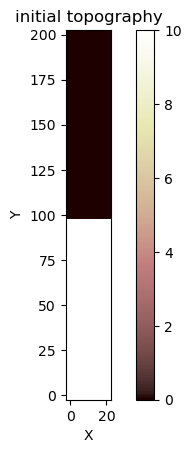

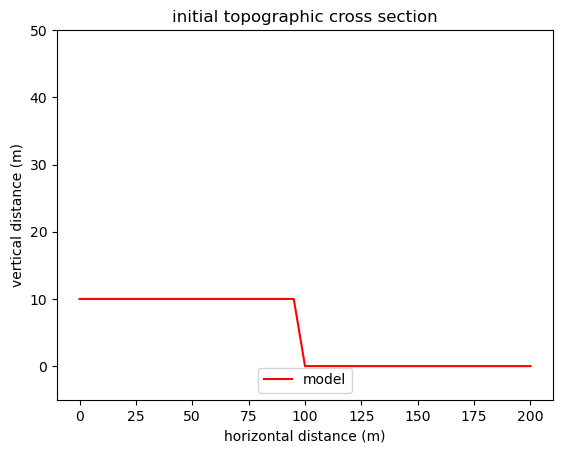

In [12]:
# Code Block 6

figure(1)
imshow_grid(mg, "topographic__elevation")
title("initial topography")
figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "r-", label="model")
ylim((-5, 50))  # may want to change upper limit if D changes
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("initial topographic cross section")

Agora estamos prontos para evoluir a paisagem.

Abaixo está o *loop* de tempo que realiza todos os cálculos.

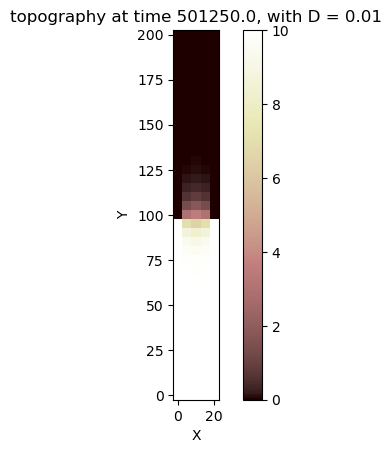

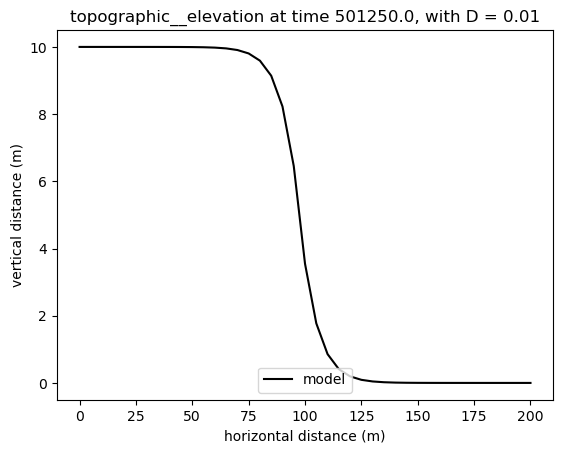

In [13]:
# Code Block 7

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, "topographic__elevation")
        title("topography at time %s, with D = %s" % (time_counter, D))
        figure(2)
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        plot(ys_grid, elev_rast[:, 2], "k-", label="model")
        xlabel("horizontal distance (m)")
        ylabel("vertical distance (m)")
        legend(loc="lower center")
        title("topographic__elevation at time %s, with D = %s" % (time_counter, D))

Agora plotamos a seção transversal final.

Text(0.5, 1.0, 'topographic cross section at time 2000000.0, with D = 0.01')

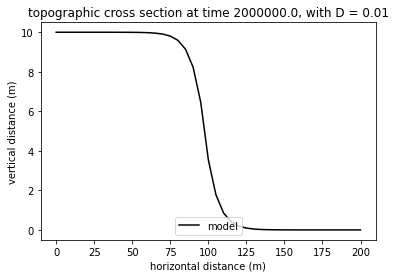

In [37]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "k-", label="model")
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("topographic cross section at time %s, with D = %s" % (time_counter, D))

Agora plotamos a inclinação mais íngreme (no sentido descendente) em toda a paisagem.

(Para calcular a inclinação mais íngreme em cada local, precisamos roteirizar o fluxo pela grade.)

Text(0.5, 1.0, 'slope of the hillslope at time 2000000.0, with D = 0.01')

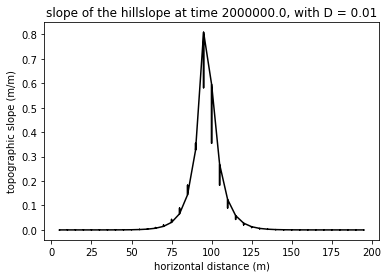

In [38]:
# Code Block 9

from landlab.components import FlowAccumulator

fr = FlowAccumulator(mg)  # intializing flow routing
fr.run_one_step()
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title("slope of the hillslope at time %s, with D = %s" % (time_counter, D))

A paisagem atingiu o estado estacionário? Como você sabe?

**Resposta sugerida:** Ainda não, mas está chegando perto. Volte e aumente o tempo de execução ou adote valores maiores de **run_time** e **dt** se quiser que a encosta atinja completamente o equilíbrio.

**O que fazer e entregar:**

1. No exemplo ilustrado aqui ($D = 0{,}01$ m$^2$ ano$^{-1}$ e $U = 0$), quanto tempo leva aproximadamente para atingir o estado estacionário? (Encontrar o valor correto de **run_time** exigirá alguma iteração.)
2. O que você **acha** que acontecerá quando aumentar $D$ (Bloco de Código onde $D$ é definido)? Como relevo máximo e perfil irão mudar quando $D$ aumenta? Responda **antes** de rodar qualquer código.
3. Agora defina $D = 0{,}1$ m$^2$ ano$^{-1}$ e refaça a evolução da paisagem. Compare o resultado com suas expectativas e explique qualquer diferença.
4. O que você **acha** que acontecerá quando aumentar **uplift_rate**? Teste numericamente, compare com sua intuição e discuta se estava correta (não há problema se estiver errada!).

Entregue um documento digitado que responda às questões acima e inclua as figuras correspondentes. Numere as figuras e faça referência a elas no texto.

Outras perguntas que você pode explorar:

1. O que acontece com o tempo até o estado estacionário quando você aumenta o comprimento da encosta?
2. A resolução da grade afeta suas respostas? Caso afirmativo, como?